In [ ]:
pip install --upgrade pip   

In [ ]:
pip install -U langgraph langchain_openai

In [1]:
import os

In [15]:
model_name = "gpt-4o-mini"  #gpt-4o-mini #gpt-3.5-turbo

In [16]:
from typing import List
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, ToolMessage
from pydantic import BaseModel, Field

In [17]:
from tempfile import TemporaryDirectory
from langchain_community.agent_toolkits import FileManagementToolkit

file_stores = FileManagementToolkit(
    selected_tools=["read_file", "write_file", "list_directory"], #use current folder
).get_tools()

read_file, write_file, list_file = file_stores

### Define State

In [18]:
DeploymentLeadPrompt = """
Role: DevOps Consultant \
Task: Analyze the input artifacts and check whether it has all information list below, \
to generate Terraform (Infra) and Ansible (app) scripts. \
Otherwise you have to get information from a user.

Input: \
1. Requirement document - {SRS} \
2. High level design - {HLD}  \
3. Coding - {CODE} \

Information: \

- What the objective of the prompt is
- What information will be passed into the prompt template to generate terraform scripts
- What information will be passed into the prompt template to generate ansible scripts

If you are not able to recognize this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to recognize all the information,  
step 1: verify your understanding with user once you received confirmation from user then move to next step
step 2: call the relevant tool."""


def get_messages_info(messages, srs, hld, code):
    return [SystemMessage(content=DeploymentLeadPrompt.format(SRS=srs, HLD=hld, CODE=code))] + messages

class DeploymentScripts(BaseModel):
    objective: str
    inputs_for_terraform: List[str]
    inputs_for_ansible: List[str]


llm = ChatOpenAI(model=model_name, temperature=0, max_retries=1)
llm_with_tool = llm.bind_tools([DeploymentScripts])

def information_gathering(state):
    messages = get_messages_info(state["messages"], state["srs"], state["hld"], state["code"])

    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

def is_clarified(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "yes" #"clarified"

    else:
        return "no" #"need more information"

In [19]:
def conclude_conversation(state):
    return {
        "messages": [
            ToolMessage(
                content="Clarified and proceeding further",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }

In [20]:
DevOpsPrompt = '''
**Role**: You are a DevOps Enginner. 

**Task**: You are required to generate deployment scripts to setup infrastructure and host the application.

**Deliverables**
- Readme <Must contain user guide to run scripts>
- Terraform Scripts <Must be helping to create infrastructure setup>
- Ansbile Scripts <Must be helping to deploy the app in specified infrastucture>
- Feedback History <Must keep all feedback with details who gave>
- Revision History <Must keep all revisions with details who incorporated>

IMP: 
- Do self-critique by validating generated deliverables with provided SRS, HLD, Codd and additional information from user \
- When critique or feedback received, ensure you thoroughly analyze and understand the feedback, then \
you must incorporate critique / feedback on previous version, share revised version to Reviewer. \
also ensure you are not lossing any existing sections and contents.
- your deliverables must match more than 95% with SRS, HLD, and Additiona information: {reqs}
'''


def get_prompt_messages(messages: list, state):
    tool_call = None
    other_msgs = []
    
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)

   
    iteration = state['iteration']
    
    scripts = state.get('scripts')
    if scripts:
        print("***** Revision Number ****", iteration)
        return[
            SystemMessage(content=DevOpsPrompt),
            HumanMessage(content=state['messages'][-1].content + state['scripts'][-1].content  + state['hld'][-1].content + state['srs'][-1].content)]
    else:
        return[
            SystemMessage(content=DevOpsPrompt.format(reqs=tool_call)),
            HumanMessage(content=state['messages'][-1].content + state['hld'][-1].content + state['srs'][-1].content)
            ] + other_msgs 

def generate_scripts(state):
    
    messages = get_prompt_messages(state["messages"], state)
    
    response = llm.invoke(messages)
    iteration = str(state['iteration'])
    file_name = "output/IaC v0." + iteration +".md"
    
    write_file.invoke({"file_path": file_name, "text": response.content})

    return {
        "messages": [response] ,
        "scripts": [response],
        
    }

In [21]:
critique = """
**Role:** DevOps Lead
**Task:** You are a critic, who analyze requirement, design and ensure both deployment scripts are complete. \
You are tasked to Analyze provided {hld}, {srs}, {code} and {scripts}.

**Highlight findings as below**
- Alignments
- Mismatches
- % of match between SRS, HLD, CODE and scripts

"""

def get_feedback_info(hld, srs, code, scripts):
    return [SystemMessage(content=critique)] + hld + srs + code + scripts

llm = ChatOpenAI(model=model_name, temperature=0, max_retries=1)

def approver(state):
    hld = state['hld']
    srs = state['srs']
    code = state['code']
    scripts = state['scripts']
    
    messages = get_feedback_info(hld, srs, code, scripts)
    

    response = llm.invoke(messages)
    max_iteration = state['max_iteration']
    iteration = state['iteration'] + 1
    
    return {
        "messages": [response],
        "iteration": iteration
    }

In [22]:
def is_approved(state):
    max_iteration = state['max_iteration']
    iteration = state['iteration']
   
    if iteration > max_iteration:
        return 'approved'
    else:
        return 'enhance'

In [23]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import END

class State(TypedDict):
    messages: Annotated[list, add_messages]
    srs: Annotated[list, add_messages]
    hld: Annotated[list, add_messages]
    code: Annotated[list, add_messages]
    scripts: Annotated[list, add_messages]
    max_iteration: int
    iteration: int
    
memory = MemorySaver()
workflow = StateGraph(State)

workflow.add_node("DevOps Consultant", information_gathering)
workflow.add_node("Prompt Generator", conclude_conversation)
workflow.add_node("DevOps Engineer", generate_scripts)
workflow.add_node("DevOps Lead",approver)

workflow.add_edge(START, "DevOps Consultant")

workflow.add_conditional_edges(
    "DevOps Consultant", 
    is_clarified, 
    {"yes": "Prompt Generator",  "no": END}
)

workflow.add_edge("Prompt Generator", "DevOps Engineer")

workflow.add_conditional_edges(
    "DevOps Lead", 
    is_approved, 
    {"approved": END, "enhance": "DevOps Engineer"}
)

workflow.add_edge("DevOps Engineer", "DevOps Lead")

graph = workflow.compile(checkpointer=memory) #, interrupt_after=['generate_requirements'])

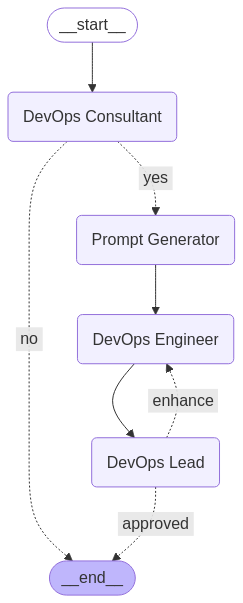

In [24]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
thread = {"configurable": {"thread_id": 2}}
SRS = read_file.invoke({"file_path": "input/srs.md"})
HLD = read_file.invoke({"file_path": "input/hld.md"})
CODE = read_file.invoke({"file_path": "input/code.md"})

count = 1

while True:
    user = input("User (q/Q to quit): ")
    if user.lower() in ["quit", "q", "Q"]:
        print("AI: Byebye")
        break
    output = None
    
    #print(count)
    #user_msg = user + " \n SRS" + SRS
    #print(count)    
    for output in graph.stream(
        {
            "messages": [HumanMessage(content=user)],
            "srs": [HumanMessage(content=SRS)],
            "hld": [HumanMessage(content=HLD)],
            "code": [HumanMessage(content=CODE)],
            "iteration" : 1,
            "max_iteration": 3,
        }, 
        config=thread, 
        stream_mode="updates"):
        #print(output)
        for key, value in output.items():
            print("***** Result from Agent: ",key)
            #print("***** value: ",value)
            
            try:
                last_message = next(iter(output.values()))["messages"][-1]
                last_message.pretty_print()
            except:
                print("pass")



User (q/Q to quit):  generate deployment scripts


***** Result from Agent:  DevOps Consultant
================================== Ai Message ==================================

To generate the deployment scripts, I need to confirm the following information based on the provided input artifacts:

1. **Objective of the prompt**: The objective is to deploy a simple task management web application using Terraform for infrastructure provisioning and Ansible for application deployment and configuration management.

2. **Information for Terraform scripts**:
   - Provision cloud resources (EC2 instance, Security Group, and basic networking).
   - Ensure secure access using basic SSH security groups.

3. **Information for Ansible scripts**:
   - Install necessary dependencies on the EC2 instance.
   - Deploy the web application with a SQLite database backend.

Please confirm if my understanding is correct or if there are any additional details you would like to provide.


User (q/Q to quit):  proceed


***** Result from Agent:  DevOps Consultant
================================== Ai Message ==================================
Tool Calls:
  DeploymentScripts (call_ZO4qkmAjIlXPD1r9CcuUQ83L)
 Call ID: call_ZO4qkmAjIlXPD1r9CcuUQ83L
  Args:
    objective: Deploy a simple task management web application using Terraform and Ansible.
    inputs_for_terraform: ['Provision cloud resources (EC2 instance, Security Group, and basic networking)', 'Ensure secure access using basic SSH security groups.']
    inputs_for_ansible: ['Install necessary dependencies on the EC2 instance', 'Deploy the web application with a SQLite database backend.']
***** Result from Agent:  Prompt Generator
================================= Tool Message =================================

Clarified and proceeding further
***** Result from Agent:  DevOps Engineer
================================== Ai Message ==================================

# Deployment Scripts for Task Management Web Application

## Readme

### User Guid

User (q/Q to quit):  q


AI: Byebye
